In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
import cv2
import matplotlib.pyplot as plt
import PIL.Image as img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,GaussianNoise,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import optimizers
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
train_dir = 'C:/Potato Project/training/Plant disease/train/'
test_dir = 'C:/Potato Project/training/Plant disease/test/'

In [3]:
print("Train Set :")
train_count = []
for folder in os.listdir(train_dir) :
    print(folder,"folder contains\t\t",len(os.listdir(train_dir+folder)),"image")
    train_count.append(len(os.listdir(train_dir+folder)))    
print()
test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder,"folder contains\t\t", len(os.listdir(test_dir+folder)),"images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot folder contains		 1642 image
Corn_(maize)___Common_rust_ folder contains		 1907 image
Corn_(maize)___healthy folder contains		 1859 image
Corn_(maize)___Northern_Leaf_Blight folder contains		 1908 image
Pepper,_bell___Bacterial_spot folder contains		 1913 image
Pepper,_bell___healthy folder contains		 1988 image
Potato___Early_blight folder contains		 1939 image
Potato___healthy folder contains		 1824 image
Potato___Late_blight folder contains		 1939 image
Tomato___Bacterial_spot folder contains		 1702 image
Tomato___Early_blight folder contains		 1920 image
Tomato___healthy folder contains		 1926 image
Tomato___Late_blight folder contains		 1851 image
Tomato___Leaf_Mold folder contains		 1882 image
Tomato___Septoria_leaf_spot folder contains		 1745 image
Tomato___Spider_mites Two-spotted_spider_mite folder contains		 1741 image
Tomato___Target_Spot folder contains		 1827 image
Tomato___Tomato_mosaic_virus folder contains		

In [7]:
IMAGE_SIZE=124
BATCH_SIZE=32

train_datagen = ImageDataGenerator(dtype='float32', 
                                   rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)
train_generator= train_datagen.flow_from_directory(train_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                shuffle=True,
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(dtype='float32', 
                                  rescale=1./255,
                                  zoom_range=0.3,
                                  horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                shuffle=True,
                                                class_mode='categorical')


Found 35264 images belonging to 19 classes.
Found 8815 images belonging to 19 classes.


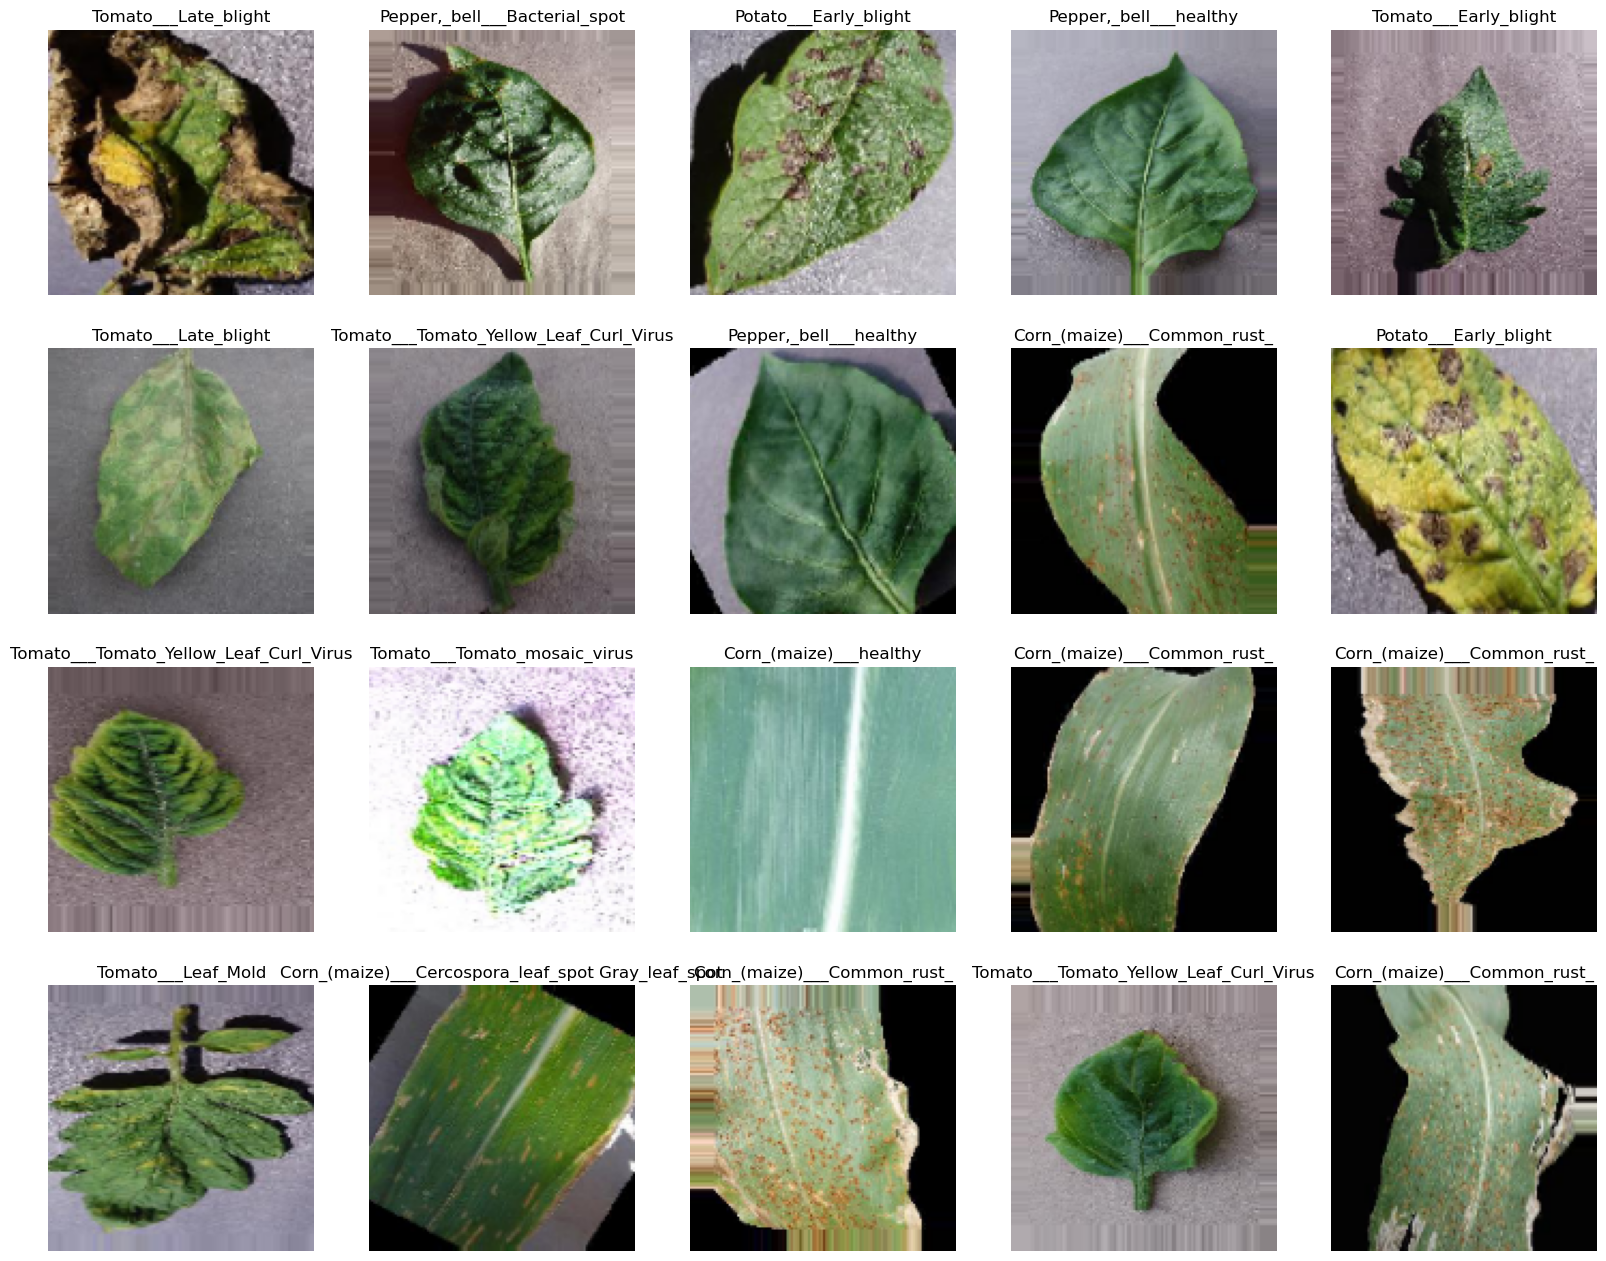

In [6]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    for i in range(0,20):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i].astype(np.uint8))
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
        plt.axis("off")
    plt.show()
    break

In [8]:
test_generator.class_indices

{'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0,
 'Corn_(maize)___Common_rust_': 1,
 'Corn_(maize)___Northern_Leaf_Blight': 2,
 'Corn_(maize)___healthy': 3,
 'Pepper,_bell___Bacterial_spot': 4,
 'Pepper,_bell___healthy': 5,
 'Potato___Early_blight': 6,
 'Potato___Late_blight': 7,
 'Potato___healthy': 8,
 'Tomato___Bacterial_spot': 9,
 'Tomato___Early_blight': 10,
 'Tomato___Late_blight': 11,
 'Tomato___Leaf_Mold': 12,
 'Tomato___Septoria_leaf_spot': 13,
 'Tomato___Spider_mites Two-spotted_spider_mite': 14,
 'Tomato___Target_Spot': 15,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 16,
 'Tomato___Tomato_mosaic_virus': 17,
 'Tomato___healthy': 18}

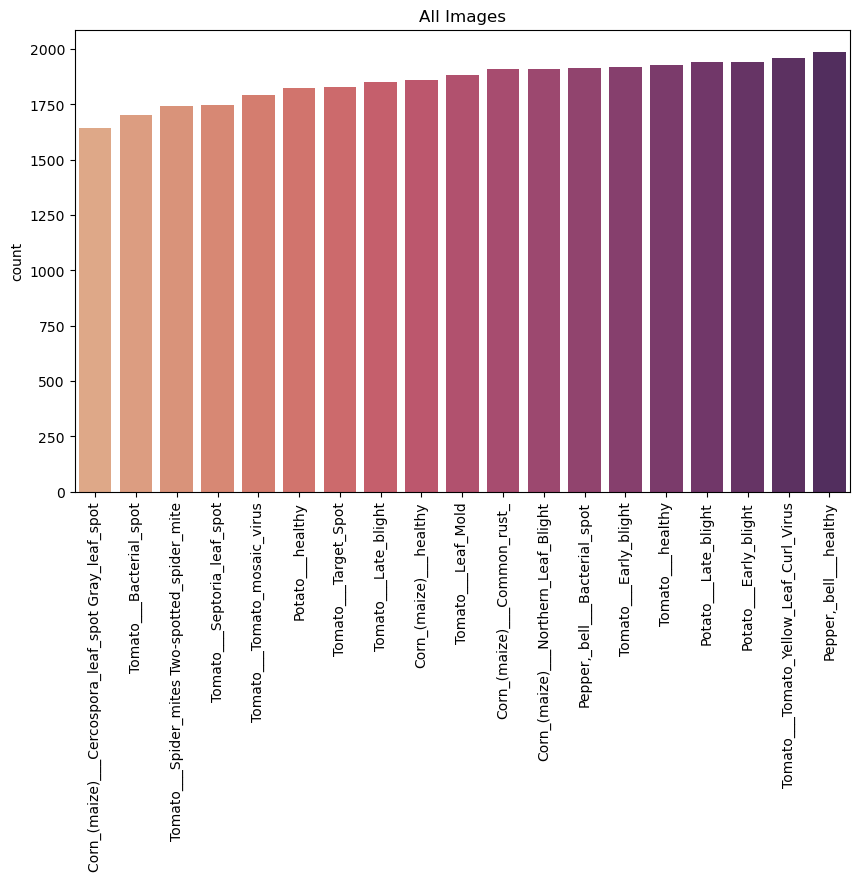

In [9]:
import seaborn as sns
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total")
plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="flare", data=df)
plt.xticks(rotation=90)
plt.ylabel("count")
plt.title("All Images")
plt.show()

In [10]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE,3))
for layer in vgg_model.layers:
    layer.trainable = False
vgg_model .summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 124, 124, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 124, 124, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 62, 62, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 62, 62, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 62, 62, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0     

In [12]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(19, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 19)                87571     
                                                                 
Total params: 14,802,259
Trainable params: 87,571
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [14]:
history_res = model.fit(train_generator,
                            steps_per_epoch = len(train_generator),
                            validation_data = test_generator,
                            validation_steps= len(test_generator),                            
                            epochs = 10)

Epoch 1/10
1102/1102 [==============================] - 3122s 3s/step - loss: 0.8393 - accuracy: 0.7315 - val_loss: 0.6075 - val_accuracy: 0.7984
Epoch 2/10
1102/1102 [==============================] - 3041s 3s/step - loss: 0.5445 - accuracy: 0.8189 - val_loss: 0.5639 - val_accuracy: 0.8115
Epoch 3/10
1102/1102 [==============================] - 3106s 3s/step - loss: 0.4775 - accuracy: 0.8393 - val_loss: 0.5025 - val_accuracy: 0.8319
Epoch 4/10
1102/1102 [==============================] - 3072s 3s/step - loss: 0.4369 - accuracy: 0.8526 - val_loss: 0.4611 - val_accuracy: 0.8416
Epoch 5/10
1102/1102 [==============================] - 3041s 3s/step - loss: 0.4125 - accuracy: 0.8609 - val_loss: 0.4212 - val_accuracy: 0.8560
Epoch 6/10
1102/1102 [==============================] - 3032s 3s/step - loss: 0.3931 - accuracy: 0.8670 - val_loss: 0.4471 - val_accuracy: 0.8465
Epoch 7/10
1102/1102 [==============================] - 3028s 3s/step - loss: 0.3792 - accuracy: 0.8718 - val_loss: 0.4420 -

In [15]:
model.evaluate(test_generator)

276/276 [==============================] - 698s 3s/step - loss: 0.4191 - accuracy: 0.8571


[0.4190598130226135, 0.8570618033409119]

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

276/276 [==============================] - 893s 3s/step - loss: 0.4312 - accuracy: 0.8545
validation accuracy : 85.44526100158691%
validation loss : 0.4312025010585785


In [23]:
model.save('Veg_mod_21.h5')
print('Model Saved!')

Model Saved!


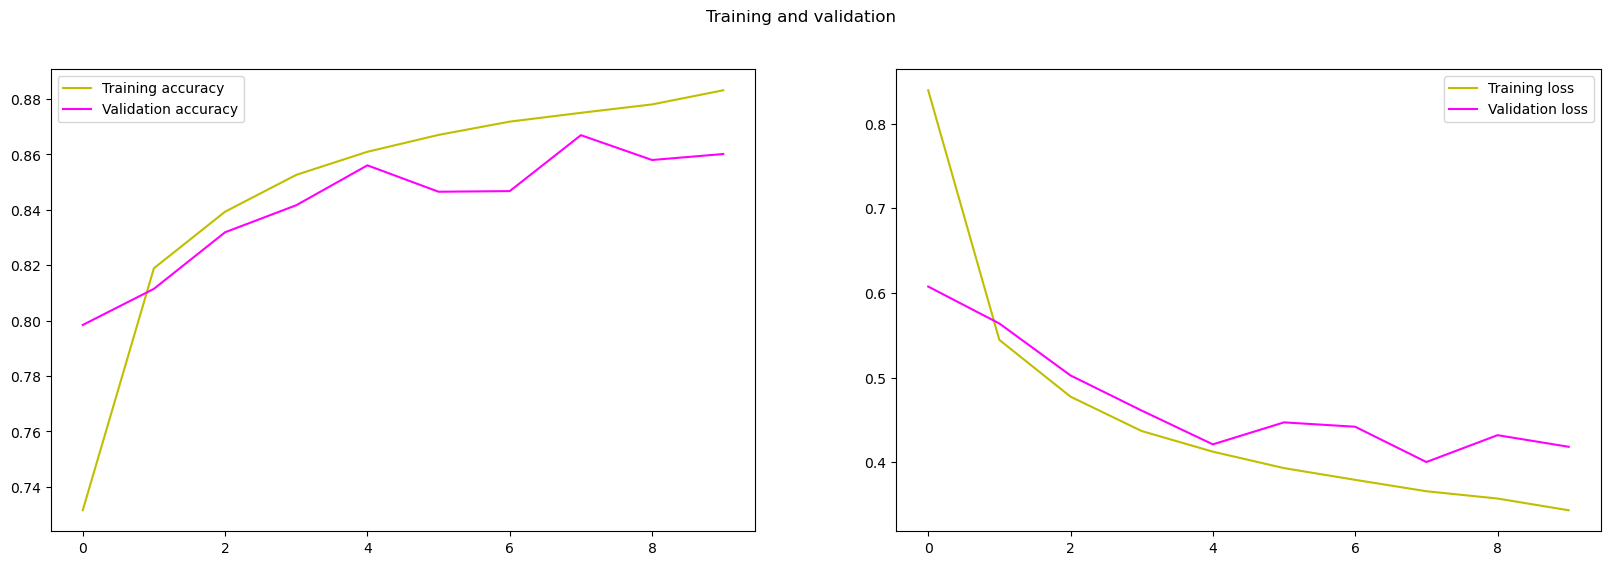

In [24]:
acc = history_res.history['accuracy']
val_acc = history_res.history['val_accuracy']
loss = history_res.history['loss']
val_loss = history_res.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'magenta', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'magenta', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [25]:
savedModel5=load_model('Veg_mod_21.h5')
savedModel5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 19)                87571     
                                                                 
Total params: 14,802,259
Trainable params: 87,571
Non-trainable params: 14,714,688
_________________________________________________________________
